# Asset Data

In [1]:
import ast
import numpy as np
import pandas as pd
from warnings import filterwarnings
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

filterwarnings('ignore')
tqdm.pandas()

## load data

In [2]:
assets_df = pd.read_csv('data_csv/all_assets.csv', index_col=0)
assets_df['channels'] = assets_df.channels.map(lambda x: ast.literal_eval(x) if type(x) == str else None)
assets_df['denom_units'] = assets_df.denom_units.map(
    lambda x: ast.literal_eval(x) if type(x) == str else None)
assets_df

,chain_name,chain_id,denom,type_asset,supply,description,denom_units,display,name,symbol,...,denom_base,type_asset_base,path,channels,chain_id_counterparty,channel_id_counterparty,supply_base,chain_id_base,one_channel,admin
0,realio,realionetwork_3301-1,ibc/ED07A3391A112B175915CD8FAF43A2DA8E4790EDE1...,ics20,1000,The native token of Osmosis,"[{'denom': 'uosmo', 'exponent': 0, 'aliases': ...",osmo,NaN,NaN,...,uosmo,sdk.coin,transfer/channel-0,[channel-0],osmosis-1,channel-1011,605276664611957,osmosis-1,True,NaN
1,loyal,loyal-main-02,ibc/0471F1C4E7AFD3F07702BEF6DC365268D64570F7C1...,ics20,100000,NaN,None,NaN,NaN,NaN,...,uosmo,sdk.coin,transfer/channel-1,[channel-1],osmo-test-4,channel-2463,NaN,NaN,True,NaN
2,loyal,loyal-main-02,ibc/C0E66D1C81D8AAF0E6896E05190FDFBC222367148F...,ics20,1000000,NaN,None,NaN,NaN,NaN,...,uaxl,sdk.coin,transfer/channel-2,[channel-2],axelar-testnet-lisbon-3,channel-165,NaN,NaN,True,NaN
3,xpla,dimension_37-1,ibc/2CC0B1B7A981ACC74854717F221008484603BB8360...,ics20,600098,NaN,None,NaN,NaN,NaN,...,uaxl,sdk.coin,transfer/channel-0,[channel-0],axelar-dojo-1,channel-49,1076502807145169,axelar-dojo-1,True,NaN
4,xpla,dimension_37-1,ibc/6771714762A6F8F541DE7C461F09C68F310621315F...,ics20,93300000000000000,NaN,None,NaN,NaN,NaN,...,wavax-wei,sdk.coin,transfer/channel-0,[channel-0],axelar-dojo-1,channel-49,11859121968723491769117,axelar-dojo-1,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11411,terra2,phoenix-1,cw20:terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4...,cw20,132499372296110,NaN,"[{'denom': 'xastro', 'exponent': 6, 'aliases':...",NaN,Staked Astroport,xASTRO,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
11412,terra2,phoenix-1,cw20:terra17gck626vgax9jpe6utm7dhx4vdzawfkt0jh...,cw20,93000000000000,NaN,"[{'denom': 'dust', 'exponent': 6, 'aliases': [...",NaN,Depegged UST,dUST,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
11413,terra2,phoenix-1,cw20:terra1xzkel96e5e8vfmqw7valzdzzv9hqasfyslc...,cw20,6564511713902,NaN,"[{'denom': 'local', 'exponent': 6, 'aliases': ...",NaN,Local Terra Token (Wormhole),LOCAL,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
11414,terra2,phoenix-1,cw20:terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0gu...,cw20,100000000000000,NaN,"[{'denom': 'sayve', 'exponent': 6, 'aliases': ...",NaN,Sayve Token,SAYVE,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


## charts

In [3]:
def aggregate_pie_plot(assets_df: pd.DataFrame, agg_column: str, n: int = 9) -> pd.Series:
    assets_by_item_row = assets_df.groupby(agg_column)['denom'].agg(np.count_nonzero).sort_values(ascending=False)
    assets_by_item = assets_by_item_row.head(n)
    if len(assets_by_item_row) > n:
        assets_by_item['remaining {0} items'.format(len(assets_by_item_row) - n)] = sum(assets_by_item_row[n:])
    return assets_by_item

In [4]:
assets_by_chain = aggregate_pie_plot(assets_df=assets_df, agg_column='chain_id')
assets_by_type_asset = aggregate_pie_plot(assets_df=assets_df, agg_column='type_asset')
assets_by_denom_base = aggregate_pie_plot(assets_df=assets_df, agg_column='denom_base')
total_assets = len(assets_df)

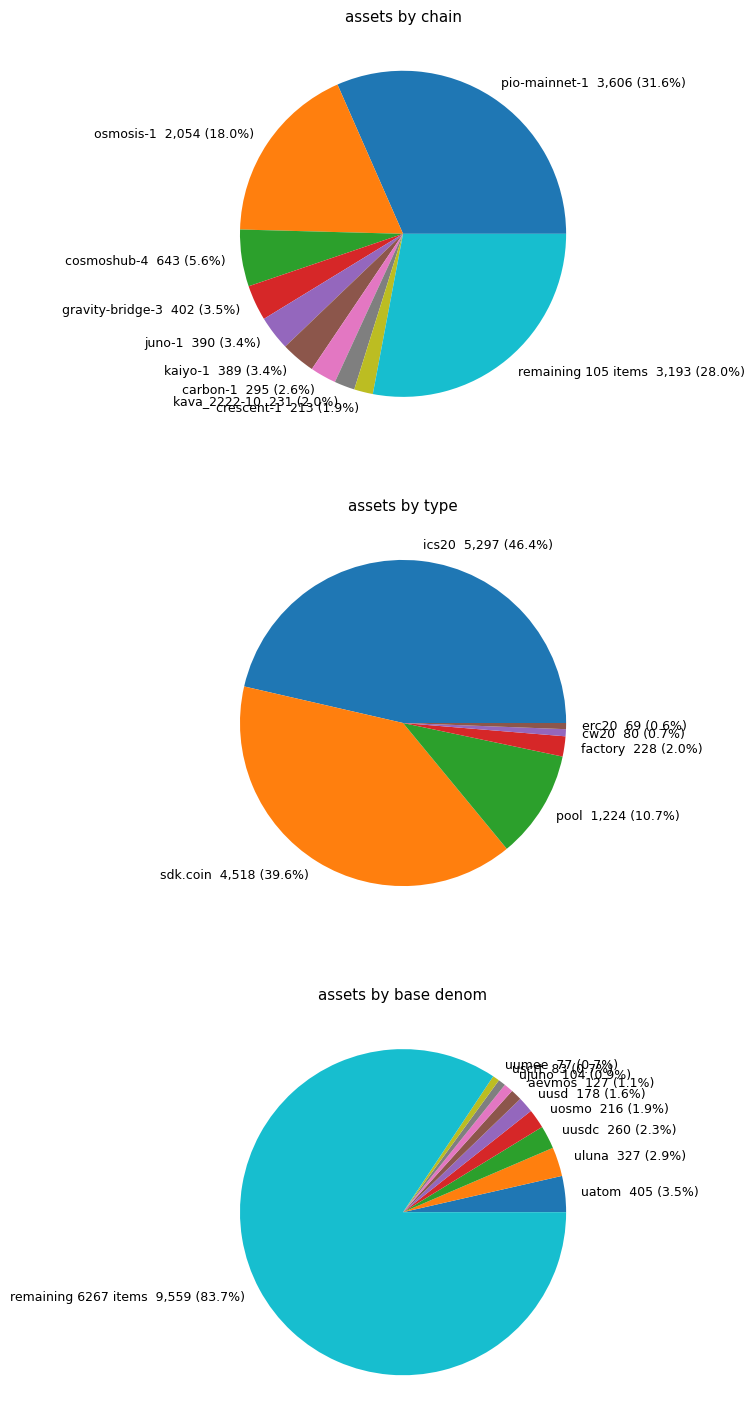

In [5]:
mpl.rcParams['figure.figsize'] = (20.0, 18.0)
plt.rcParams.update({'font.size': 9})

fig, [ax1, ax2, ax3] = plt.subplots(ncols=1, nrows=3)

chain_labels = [f'{_chain_id}  {assets_by_chain[_chain_id]:>,.0f} ({assets_by_chain[_chain_id] / total_assets:.1%})' for _chain_id in assets_by_chain.keys()]
type_asset_labels = [f'{_type_asset}  {assets_by_type_asset[_type_asset]:>,.0f} ({assets_by_type_asset[_type_asset] / total_assets:.1%})' for _type_asset in assets_by_type_asset.keys()]
denom_base_labels = [f'{_denom_base}  {assets_by_denom_base[_denom_base]:>,.0f} ({assets_by_denom_base[_denom_base] / total_assets:.1%})' for _denom_base in assets_by_denom_base.keys()]

ax1.pie(assets_by_chain, labels=chain_labels)
ax1.set_title(label='assets by chain')

ax2.pie(assets_by_type_asset, labels=type_asset_labels)
ax2.set_title(label='assets by type')

ax3.pie(assets_by_denom_base, labels=denom_base_labels)
ax3.set_title(label='assets by base denom')

plt.show()